# Clustering Experiments Pipeline
## Food Price Clustering Project - Phase 1

This notebook implements comprehensive clustering analysis on Indonesian cities based on food price patterns using three different algorithms.

### Objectives:
1. **Load** feature matrix from feature engineering phase
2. **Explore** data characteristics and prepare for clustering
3. **Scale** features appropriately for clustering algorithms
4. **Determine** optimal number of clusters (k=2 to k=10)
5. **Implement** three clustering algorithms:
   - **K-Means Clustering**: Fast, efficient baseline
   - **Fuzzy C-Means (FCM)**: Soft clustering with membership degrees
   - **Spectral Clustering**: Handles non-convex cluster shapes
6. **Evaluate** each configuration with multiple metrics:
   - **Silhouette Score**: Cluster cohesion and separation
   - **Davies-Bouldin Index**: Cluster compactness vs separation
   - **Computation Time**: Algorithm efficiency
7. **Compare** algorithms and select best performer
8. **Interpret** business meaning of clusters

### Clustering Strategy:
- **Systematic Evaluation**: Test k=2 to k=10 for each algorithm
- **Multiple Metrics**: Comprehensive evaluation with 3 key metrics
- **Reproducible Results**: Fixed random seeds for consistency
- **Business Focus**: Interpret clusters in terms of market dynamics
- **Visualization Ready**: Prepare data for 2D visualization using PCA/t-SNE

---


In [1]:
"""
Setup and Environment Configuration
"""
import sys
import os
import logging
import time
import warnings
from pathlib import Path
from datetime import datetime
from typing import List, Dict, Any, Optional, Union, Tuple

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.spatial.distance import cdist

# Scikit-learn imports
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.metrics.pairwise import euclidean_distances

# Fuzzy C-Means
try:
    import skfuzzy as fuzz
    FUZZY_AVAILABLE = True
except ImportError:
    print("⚠️ Warning: scikit-fuzzy not available. Fuzzy C-Means will be skipped.")
    FUZZY_AVAILABLE = False

# UMAP for visualization (optional)
try:
    import umap
    UMAP_AVAILABLE = True
except ImportError:
    print("⚠️ Warning: umap-learn not available. Will use t-SNE for visualization.")
    UMAP_AVAILABLE = False

# Configuration
from pydantic import BaseModel, Field, field_validator

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

def setup_environment() -> Dict[str, Any]:
    """
    Setup notebook environment and verify paths.
    
    Returns:
        Dict containing environment information and path verification results.
    """
    # Fix working directory - ensure we're running from project root
    notebook_dir = Path.cwd()
    project_root = notebook_dir.parent if notebook_dir.name == 'notebooks' else notebook_dir
    
    # Change to project root so all relative paths work correctly
    os.chdir(project_root)
    
    # Verify critical paths
    paths_info = {
        'notebook_dir': notebook_dir,
        'project_root': project_root,
        'current_dir': Path.cwd(),
        'features_data_path': Path('data/features'),
        'features_data_exists': Path('data/features').exists(),
        'results_path': Path('results'),
        'results_exists': Path('results').exists()
    }
    
    # Create results directory if it doesn't exist
    if not paths_info['results_exists']:
        paths_info['results_path'].mkdir(parents=True, exist_ok=True)
    
    # Environment info
    env_info = {
        'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'python_version': sys.version.split()[0],
        'pandas_version': pd.__version__,
        'numpy_version': np.__version__,
        'sklearn_version': __import__('sklearn').__version__,
        'fuzzy_available': FUZZY_AVAILABLE,
        'umap_available': UMAP_AVAILABLE
    }
    
    return {**paths_info, **env_info}

def setup_logging(log_level: str = "INFO") -> logging.Logger:
    """
    Setup logging for clustering experiments.
    
    Args:
        log_level: Logging level (DEBUG, INFO, WARNING, ERROR)
        
    Returns:
        Configured logger instance
    """
    # Create logger
    logger = logging.getLogger("clustering_experiments")
    logger.setLevel(getattr(logging, log_level.upper()))
    
    # Clear any existing handlers
    logger.handlers.clear()
    
    # Create formatter
    formatter = logging.Formatter(
        '%(asctime)s - %(levelname)s - %(message)s'
    )
    
    # Console handler
    console_handler = logging.StreamHandler()
    console_handler.setLevel(getattr(logging, log_level.upper()))
    console_handler.setFormatter(formatter)
    logger.addHandler(console_handler)
    
    return logger

# Setup environment
env_info = setup_environment()
logger = setup_logging("INFO")

# Display environment information
print("🧪 Clustering Experiments Pipeline - Environment Setup")
print("=" * 60)
print(f"📅 Notebook run at: {env_info['timestamp']}")
print(f"🐍 Python version: {env_info['python_version']}")
print(f"🐼 Pandas version: {env_info['pandas_version']}")
print(f"🔢 NumPy version: {env_info['numpy_version']}")
print(f"🤖 Scikit-learn version: {env_info['sklearn_version']}")
print(f"🌀 Fuzzy C-Means: {'✅ AVAILABLE' if env_info['fuzzy_available'] else '❌ NOT AVAILABLE'}")
print(f"🗺️ UMAP: {'✅ AVAILABLE' if env_info['umap_available'] else '❌ NOT AVAILABLE'}")
print()
print("📂 Path Verification:")
print(f"   Current working directory: {env_info['current_dir']}")
print(f"   Features data path: {env_info['features_data_path']} ({'✅ EXISTS' if env_info['features_data_exists'] else '❌ MISSING'})")
print(f"   Results path: {env_info['results_path']} ({'✅ EXISTS' if env_info['results_exists'] else '❌ MISSING'})")
print("=" * 60)


c:\Users\UNTAR\Semester 7\SKRIPSI\program\food-price-clustering\food-price-clustering\myenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🧪 Clustering Experiments Pipeline - Environment Setup
📅 Notebook run at: 2025-10-06 17:58:15
🐍 Python version: 3.12.7
🐼 Pandas version: 2.3.3
🔢 NumPy version: 2.3.3
🤖 Scikit-learn version: 1.7.2
🌀 Fuzzy C-Means: ✅ AVAILABLE
🗺️ UMAP: ✅ AVAILABLE

📂 Path Verification:
   Current working directory: c:\Users\UNTAR\Semester 7\SKRIPSI\program\food-price-clustering\food-price-clustering
   Features data path: data\features (✅ EXISTS)
   Results path: results (✅ EXISTS)


In [2]:
"""
Configuration for Clustering Experiments
"""

class ClusteringConfig(BaseModel):
    """
    Configuration class for clustering experiments.
    
    Uses Pydantic for validation and type checking.
    """
    # Random seed for reproducibility
    random_state: int = Field(
        default=42,
        description="Random seed for reproducible results"
    )
    
    # Clustering parameters
    k_range: Tuple[int, int] = Field(
        default=(2, 10),
        description="Range of k values to test (min, max inclusive)"
    )
    
    # Feature scaling method
    scaling_method: str = Field(
        default="robust",
        description="Feature scaling method: 'standard', 'minmax', or 'robust'"
    )
    
    # Algorithm-specific parameters
    kmeans_params: Dict[str, Any] = Field(
        default={
            "init": "k-means++",
            "n_init": 10,
            "max_iter": 300,
            "tol": 1e-4
        },
        description="K-Means algorithm parameters"
    )
    
    spectral_params: Dict[str, Any] = Field(
        default={
            "affinity": "rbf",
            "gamma": 1.0,
            "n_init": 10
        },
        description="Spectral Clustering algorithm parameters"
    )
    
    fcm_params: Dict[str, Any] = Field(
        default={
            "m": 2.0,
            "error": 0.005,
            "maxiter": 1000
        },
        description="Fuzzy C-Means algorithm parameters"
    )
    
    # Visualization parameters
    pca_components: int = Field(
        default=10,
        description="Number of PCA components for dimensionality reduction"
    )
    
    visualization_method: str = Field(
        default="tsne",
        description="2D visualization method: 'tsne' or 'umap'"
    )
    
    # Output configuration
    save_results: bool = Field(
        default=True,
        description="Whether to save clustering results to files"
    )
    
    @field_validator('scaling_method')
    @classmethod
    def validate_scaling_method(cls, v):
        valid_methods = ["standard", "minmax", "robust"]
        if v not in valid_methods:
            raise ValueError(f"Scaling method must be one of: {valid_methods}")
        return v
    
    @field_validator('k_range')
    @classmethod
    def validate_k_range(cls, v):
        min_k, max_k = v
        if min_k < 2:
            raise ValueError("Minimum k must be at least 2")
        if max_k > 20:
            raise ValueError("Maximum k should not exceed 20 for practical reasons")
        if min_k >= max_k:
            raise ValueError("Minimum k must be less than maximum k")
        return v
    
    @field_validator('visualization_method')
    @classmethod
    def validate_visualization_method(cls, v):
        valid_methods = ["tsne", "umap"]
        if v not in valid_methods:
            raise ValueError(f"Visualization method must be one of: {valid_methods}")
        return v

def find_latest_feature_matrix(features_dir: Path) -> Optional[Path]:
    """
    Find the most recent feature matrix file.
    
    Args:
        features_dir: Directory containing feature files
        
    Returns:
        Path to the most recent feature matrix CSV file, or None if not found
    """
    csv_files = list(features_dir.glob("feature_matrix_*.csv"))
    
    if not csv_files:
        return None
    
    # Sort by modification time, most recent first
    csv_files.sort(key=lambda x: x.stat().st_mtime, reverse=True)
    return csv_files[0]

# Initialize configuration
config = ClusteringConfig(
    save_results=False
)

# Find input feature matrix
features_dir = Path("data/features")
feature_matrix_file = find_latest_feature_matrix(features_dir)

print("⚙️ Clustering Experiments Configuration")
print("=" * 50)
print(f"🎲 Random State: {config.random_state}")
print(f"📊 K Range: {config.k_range[0]} to {config.k_range[1]}")
print(f"📏 Scaling Method: {config.scaling_method}")
print(f"🔍 PCA Components: {config.pca_components}")
print(f"📈 Visualization: {config.visualization_method}")
print(f"💾 Save Results: {'✅ YES' if config.save_results else '❌ NO'}")
print(f"📁 Feature Matrix: {feature_matrix_file.name if feature_matrix_file else '❌ NOT FOUND'}")
print("=" * 50)

if not feature_matrix_file:
    raise FileNotFoundError("No feature matrix file found in data/features/")

logger.info(f"Using feature matrix: {feature_matrix_file}")
logger.info(f"Configuration loaded: k={config.k_range}, scaling={config.scaling_method}")


2025-10-06 17:58:32,915 - INFO - Using feature matrix: data\features\feature_matrix_20251006_175633.csv
2025-10-06 17:58:32,915 - INFO - Configuration loaded: k=(2, 10), scaling=robust


⚙️ Clustering Experiments Configuration
🎲 Random State: 42
📊 K Range: 2 to 10
📏 Scaling Method: robust
🔍 PCA Components: 10
📈 Visualization: tsne
💾 Save Results: ❌ NO
📁 Feature Matrix: feature_matrix_20251006_175633.csv


## Data Loading and Exploration

Load the feature matrix and perform initial exploration to understand the data characteristics before clustering.


In [3]:
"""
Load and Explore Feature Matrix
"""

def load_feature_matrix(file_path: Path) -> pd.DataFrame:
    """
    Load feature matrix from CSV file.
    
    Args:
        file_path: Path to feature matrix CSV file
        
    Returns:
        DataFrame with features
    """
    logger.info(f"Loading feature matrix from: {file_path}")
    
    # Load data
    df = pd.read_csv(file_path, index_col=0)  # City names as index
    
    logger.info(f"Feature matrix loaded: {df.shape}")
    return df

def explore_feature_matrix(df: pd.DataFrame) -> Dict[str, Any]:
    """
    Perform comprehensive exploration of the feature matrix.
    
    Args:
        df: Feature matrix DataFrame
        
    Returns:
        Dictionary with exploration results
    """
    exploration_results = {
        'basic_info': {
            'shape': df.shape,
            'cities': len(df),
            'features': len(df.columns),
            'memory_usage_mb': df.memory_usage(deep=True).sum() / 1024**2
        },
        'data_quality': {
            'missing_values': df.isnull().sum().sum(),
            'duplicate_rows': df.duplicated().sum(),
            'infinite_values': np.isinf(df.select_dtypes(include=[np.number])).sum().sum()
        },
        'feature_statistics': {
            'numeric_features': len(df.select_dtypes(include=[np.number]).columns),
            'feature_ranges': {},
            'correlation_summary': {}
        }
    }
    
    # Calculate feature ranges by type
    numeric_df = df.select_dtypes(include=[np.number])
    
    for feature_type in ['avg', 'cv', 'trend']:
        type_cols = [col for col in numeric_df.columns if col.endswith(f'_{feature_type}')]
        if type_cols:
            type_data = numeric_df[type_cols]
            exploration_results['feature_statistics']['feature_ranges'][feature_type] = {
                'min': type_data.min().min(),
                'max': type_data.max().max(),
                'mean': type_data.mean().mean(),
                'std': type_data.std().mean()
            }
    
    # Correlation analysis
    corr_matrix = numeric_df.corr()
    exploration_results['feature_statistics']['correlation_summary'] = {
        'max_correlation': corr_matrix.abs().max().max(),
        'mean_correlation': corr_matrix.abs().mean().mean(),
        'highly_correlated_pairs': len(corr_matrix[corr_matrix.abs() > 0.8].stack()) - len(corr_matrix)
    }
    
    return exploration_results

# Load the feature matrix
feature_matrix = load_feature_matrix(feature_matrix_file)

# Explore the data
exploration_results = explore_feature_matrix(feature_matrix)

print("📊 Feature Matrix Exploration Results")
print("=" * 60)

# Basic info
basic_info = exploration_results['basic_info']
print(f"📋 Basic Information:")
print(f"   Shape: {basic_info['shape'][0]} cities × {basic_info['shape'][1]} features")
print(f"   Memory Usage: {basic_info['memory_usage_mb']:.2f} MB")

# Data quality
quality = exploration_results['data_quality']
print(f"\n✅ Data Quality:")
print(f"   Missing Values: {quality['missing_values']}")
print(f"   Duplicate Rows: {quality['duplicate_rows']}")
print(f"   Infinite Values: {quality['infinite_values']}")

# Feature statistics
stats = exploration_results['feature_statistics']
print(f"\n📈 Feature Statistics:")
print(f"   Numeric Features: {stats['numeric_features']}")

for feature_type, ranges in stats['feature_ranges'].items():
    print(f"   {feature_type.upper()} Features:")
    print(f"     Range: {ranges['min']:.3f} to {ranges['max']:.3f}")
    print(f"     Mean: {ranges['mean']:.3f} ± {ranges['std']:.3f}")

# Correlation summary
corr_summary = stats['correlation_summary']
print(f"\n🔗 Correlation Analysis:")
print(f"   Max Correlation: {corr_summary['max_correlation']:.3f}")
print(f"   Mean Correlation: {corr_summary['mean_correlation']:.3f}")
print(f"   Highly Correlated Pairs (>0.8): {corr_summary['highly_correlated_pairs']}")

# Display sample of the data
print(f"\n📋 Sample Cities and Features:")
print(feature_matrix.head().to_string())

# Show city names
print(f"\n🏙️ Cities in Dataset ({len(feature_matrix)}):")
cities = feature_matrix.index.tolist()
for i in range(0, len(cities), 5):  # Show 5 cities per line
    line_cities = cities[i:i+5]
    print(f"   {', '.join(line_cities)}")

print("=" * 60)


2025-10-06 17:58:38,623 - INFO - Loading feature matrix from: data\features\feature_matrix_20251006_175633.csv
2025-10-06 17:58:38,642 - INFO - Feature matrix loaded: (69, 30)


📊 Feature Matrix Exploration Results
📋 Basic Information:
   Shape: 69 cities × 30 features
   Memory Usage: 0.02 MB

✅ Data Quality:
   Missing Values: 0
   Duplicate Rows: 0
   Infinite Values: 0

📈 Feature Statistics:
   Numeric Features: 30
   AVG Features:
     Range: 11230.077 to 149930.996
     Mean: 39353.946 ± 4280.968
   CV Features:
     Range: 0.030 to 0.499
     Mean: 0.181 ± 0.028
   TREND Features:
     Range: -9.398 to 24.917
     Mean: 4.750 ± 1.718

🔗 Correlation Analysis:
   Max Correlation: 1.000
   Mean Correlation: 0.323
   Highly Correlated Pairs (>0.8): 12

📋 Sample Cities and Features:
                     Beras_avg  Beras_cv  Beras_trend  Telur Ayam_avg  Telur Ayam_cv  Telur Ayam_trend  Daging Ayam_avg  Daging Ayam_cv  Daging Ayam_trend  Daging Sapi_avg  Daging Sapi_cv  Daging Sapi_trend  Bawang Merah_avg  Bawang Merah_cv  Bawang Merah_trend  Bawang Putih_avg  Bawang Putih_cv  Bawang Putih_trend  Cabai Merah_avg  Cabai Merah_cv  Cabai Merah_trend  Cabai Rawit_

## Data Preparation and Scaling

Prepare the data for clustering by applying appropriate feature scaling and creating the final dataset for analysis.


In [4]:
"""
Feature Scaling and Data Preparation
"""

def prepare_clustering_data(df: pd.DataFrame, scaling_method: str = "standard", random_state: int = 42) -> Tuple[np.ndarray, pd.DataFrame, Any]:
    """
    Prepare data for clustering by scaling features.
    
    Args:
        df: Feature matrix DataFrame
        scaling_method: Scaling method ('standard', 'minmax', 'robust')
        random_state: Random seed for reproducibility
        
    Returns:
        Tuple of (scaled_features, original_df, scaler_object)
    """
    logger.info(f"Preparing data for clustering with {scaling_method} scaling")
    
    # Select only numeric features
    numeric_df = df.select_dtypes(include=[np.number])
    
    # Initialize scaler based on method
    if scaling_method == "standard":
        scaler = StandardScaler()
    elif scaling_method == "minmax":
        scaler = MinMaxScaler()
    elif scaling_method == "robust":
        scaler = RobustScaler()
    else:
        raise ValueError(f"Unknown scaling method: {scaling_method}")
    
    # Fit and transform the data
    scaled_features = scaler.fit_transform(numeric_df)
    
    logger.info(f"Data scaled: {scaled_features.shape}")
    logger.info(f"Scaled features - Mean: {scaled_features.mean():.6f}, Std: {scaled_features.std():.6f}")
    
    return scaled_features, numeric_df, scaler

def create_pca_representation(X: np.ndarray, n_components: int = 10, random_state: int = 42) -> Tuple[np.ndarray, PCA]:
    """
    Create PCA representation for visualization and analysis.
    
    Args:
        X: Scaled feature matrix
        n_components: Number of PCA components
        random_state: Random seed
        
    Returns:
        Tuple of (pca_features, pca_object)
    """
    logger.info(f"Creating PCA representation with {n_components} components")
    
    pca = PCA(n_components=n_components, random_state=random_state)
    pca_features = pca.fit_transform(X)
    
    # Calculate explained variance
    explained_variance_ratio = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance_ratio)
    
    logger.info(f"PCA completed: {pca_features.shape}")
    logger.info(f"Explained variance (first 5 components): {explained_variance_ratio[:5]}")
    logger.info(f"Cumulative variance (first 5 components): {cumulative_variance[:5]}")
    
    return pca_features, pca

# Prepare the data for clustering
X_scaled, X_original, scaler = prepare_clustering_data(
    feature_matrix, 
    config.scaling_method, 
    config.random_state
)

# Create PCA representation
X_pca, pca = create_pca_representation(
    X_scaled, 
    config.pca_components, 
    config.random_state
)

print("🔧 Data Preparation Results")
print("=" * 50)
print(f"📊 Original Features: {X_original.shape}")
print(f"📏 Scaled Features: {X_scaled.shape}")
print(f"🔍 PCA Features: {X_pca.shape}")
print(f"📈 Scaling Method: {config.scaling_method}")

# Show scaling statistics
print(f"\n📊 Scaling Statistics:")
print(f"   Original - Mean: {X_original.mean().mean():.3f}, Std: {X_original.std().mean():.3f}")
print(f"   Scaled - Mean: {X_scaled.mean():.6f}, Std: {X_scaled.std():.6f}")

# Show PCA statistics
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

print(f"\n🔍 PCA Analysis:")
print(f"   Components: {len(explained_variance)}")
print(f"   Explained Variance (first 5): {explained_variance[:5]}")
print(f"   Cumulative Variance (first 5): {cumulative_variance[:5]}")
print(f"   Total Variance Explained: {cumulative_variance[-1]:.3f}")

# Display feature names for reference
print(f"\n📋 Feature Names ({len(X_original.columns)}):")
feature_names = X_original.columns.tolist()
for i in range(0, len(feature_names), 3):  # Show 3 features per line
    line_features = feature_names[i:i+3]
    print(f"   {', '.join(line_features)}")

print("=" * 50)

# Store city names for later use
city_names = feature_matrix.index.tolist()
logger.info(f"Data preparation completed. Ready for clustering {len(city_names)} cities.")


2025-10-06 17:58:57,078 - INFO - Preparing data for clustering with robust scaling
2025-10-06 17:58:57,085 - INFO - Data scaled: (69, 30)
2025-10-06 17:58:57,086 - INFO - Scaled features - Mean: 0.045288, Std: 1.091685
2025-10-06 17:58:57,086 - INFO - Creating PCA representation with 10 components
2025-10-06 17:58:57,087 - INFO - PCA completed: (69, 10)
2025-10-06 17:58:57,088 - INFO - Explained variance (first 5 components): [0.27306693 0.17513449 0.13360695 0.11732054 0.05048138]
2025-10-06 17:58:57,088 - INFO - Cumulative variance (first 5 components): [0.27306693 0.44820142 0.58180837 0.69912891 0.74961029]
2025-10-06 17:58:57,091 - INFO - Data preparation completed. Ready for clustering 69 cities.


🔧 Data Preparation Results
📊 Original Features: (69, 30)
📏 Scaled Features: (69, 30)
🔍 PCA Features: (69, 10)
📈 Scaling Method: robust

📊 Scaling Statistics:
   Original - Mean: 13119.625, Std: 1427.571
   Scaled - Mean: 0.045288, Std: 1.091685

🔍 PCA Analysis:
   Components: 10
   Explained Variance (first 5): [0.27306693 0.17513449 0.13360695 0.11732054 0.05048138]
   Cumulative Variance (first 5): [0.27306693 0.44820142 0.58180837 0.69912891 0.74961029]
   Total Variance Explained: 0.927

📋 Feature Names (30):
   Beras_avg, Beras_cv, Beras_trend
   Telur Ayam_avg, Telur Ayam_cv, Telur Ayam_trend
   Daging Ayam_avg, Daging Ayam_cv, Daging Ayam_trend
   Daging Sapi_avg, Daging Sapi_cv, Daging Sapi_trend
   Bawang Merah_avg, Bawang Merah_cv, Bawang Merah_trend
   Bawang Putih_avg, Bawang Putih_cv, Bawang Putih_trend
   Cabai Merah_avg, Cabai Merah_cv, Cabai Merah_trend
   Cabai Rawit_avg, Cabai Rawit_cv, Cabai Rawit_trend
   Minyak Goreng_avg, Minyak Goreng_cv, Minyak Goreng_trend
   G

## Clustering Algorithm Implementations

Implement the three clustering algorithms with comprehensive evaluation for k=2 to k=10.


In [5]:
"""
Clustering Evaluation Functions
"""

def evaluate_clustering(X: np.ndarray, labels: np.ndarray) -> Dict[str, float]:
    """
    Evaluate clustering results using multiple metrics.
    
    Args:
        X: Feature matrix
        labels: Cluster labels
        
    Returns:
        Dictionary with evaluation metrics
    """
    n_clusters = len(np.unique(labels))
    
    # Calculate metrics
    metrics = {}
    
    # Silhouette Score (higher is better, range: -1 to 1)
    if n_clusters > 1 and n_clusters < len(X):
        metrics['silhouette_score'] = silhouette_score(X, labels)
    else:
        metrics['silhouette_score'] = -1.0
    
    # Davies-Bouldin Index (lower is better, range: 0 to inf)
    if n_clusters > 1:
        metrics['davies_bouldin_index'] = davies_bouldin_score(X, labels)
    else:
        metrics['davies_bouldin_index'] = float('inf')
    
    # Calinski-Harabasz Score (higher is better, range: 0 to inf)
    if n_clusters > 1 and n_clusters < len(X):
        metrics['calinski_harabasz_score'] = calinski_harabasz_score(X, labels)
    else:
        metrics['calinski_harabasz_score'] = 0.0
    
    return metrics

def run_kmeans_clustering(X: np.ndarray, k_range: Tuple[int, int], config: ClusteringConfig) -> Dict[int, Dict[str, Any]]:
    """
    Run K-Means clustering for different k values.
    
    Args:
        X: Scaled feature matrix
        k_range: Range of k values to test
        config: Configuration object
        
    Returns:
        Dictionary with results for each k value
    """
    logger.info("Starting K-Means clustering experiments")
    
    results = {}
    min_k, max_k = k_range
    
    for k in range(min_k, max_k + 1):
        logger.info(f"Running K-Means with k={k}")
        
        # Record start time
        start_time = time.time()
        
        # Initialize and fit K-Means
        kmeans = KMeans(
            n_clusters=k,
            random_state=config.random_state,
            **config.kmeans_params
        )
        
        labels = kmeans.fit_predict(X)
        
        # Record end time
        end_time = time.time()
        computation_time = end_time - start_time
        
        # Evaluate clustering
        metrics = evaluate_clustering(X, labels)
        
        # Store results
        results[k] = {
            'algorithm': 'K-Means',
            'k': k,
            'labels': labels,
            'cluster_centers': kmeans.cluster_centers_,
            'inertia': kmeans.inertia_,
            'n_iter': kmeans.n_iter_,
            'silhouette_score': metrics['silhouette_score'],
            'davies_bouldin_index': metrics['davies_bouldin_index'],
            'calinski_harabasz_score': metrics['calinski_harabasz_score'],
            'computation_time': computation_time,
            'model': kmeans
        }
        
        logger.info(f"K-Means k={k}: Silhouette={metrics['silhouette_score']:.3f}, "
                   f"Davies-Bouldin={metrics['davies_bouldin_index']:.3f}, "
                   f"Time={computation_time:.3f}s")
    
    logger.info("K-Means clustering experiments completed")
    return results

def run_fuzzy_cmeans_clustering(X: np.ndarray, k_range: Tuple[int, int], config: ClusteringConfig) -> Dict[int, Dict[str, Any]]:
    """
    Run Fuzzy C-Means clustering for different k values.
    
    Args:
        X: Scaled feature matrix
        k_range: Range of k values to test
        config: Configuration object
        
    Returns:
        Dictionary with results for each k value
    """
    if not FUZZY_AVAILABLE:
        logger.warning("Fuzzy C-Means not available, skipping")
        return {}
    
    logger.info("Starting Fuzzy C-Means clustering experiments")
    
    results = {}
    min_k, max_k = k_range
    
    for k in range(min_k, max_k + 1):
        logger.info(f"Running Fuzzy C-Means with k={k}")
        
        # Record start time
        start_time = time.time()
        
        # Run Fuzzy C-Means
        try:
            cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
                X.T,  # Transpose for skfuzzy format
                k,
                config.fcm_params['m'],
                error=config.fcm_params['error'],
                maxiter=config.fcm_params['maxiter'],
                init=None,
                seed=config.random_state
            )
            
            # Get hard clustering labels (highest membership)
            labels = np.argmax(u, axis=0)
            
            # Record end time
            end_time = time.time()
            computation_time = end_time - start_time
            
            # Evaluate clustering
            metrics = evaluate_clustering(X, labels)
            
            # Store results
            results[k] = {
                'algorithm': 'Fuzzy C-Means',
                'k': k,
                'labels': labels,
                'cluster_centers': cntr,
                'membership_matrix': u,
                'fuzzy_partition_coefficient': fpc,
                'objective_function': jm[-1],  # Final objective function value
                'n_iter': len(jm),
                'silhouette_score': metrics['silhouette_score'],
                'davies_bouldin_index': metrics['davies_bouldin_index'],
                'calinski_harabasz_score': metrics['calinski_harabasz_score'],
                'computation_time': computation_time
            }
            
            logger.info(f"Fuzzy C-Means k={k}: Silhouette={metrics['silhouette_score']:.3f}, "
                       f"Davies-Bouldin={metrics['davies_bouldin_index']:.3f}, "
                       f"FPC={fpc:.3f}, Time={computation_time:.3f}s")
            
        except Exception as e:
            logger.error(f"Fuzzy C-Means failed for k={k}: {str(e)}")
            continue
    
    logger.info("Fuzzy C-Means clustering experiments completed")
    return results

def run_spectral_clustering(X: np.ndarray, k_range: Tuple[int, int], config: ClusteringConfig) -> Dict[int, Dict[str, Any]]:
    """
    Run Spectral clustering for different k values.
    
    Args:
        X: Scaled feature matrix
        k_range: Range of k values to test
        config: Configuration object
        
    Returns:
        Dictionary with results for each k value
    """
    logger.info("Starting Spectral clustering experiments")
    
    results = {}
    min_k, max_k = k_range
    
    for k in range(min_k, max_k + 1):
        logger.info(f"Running Spectral clustering with k={k}")
        
        # Record start time
        start_time = time.time()
        
        try:
            # Initialize and fit Spectral Clustering
            spectral = SpectralClustering(
                n_clusters=k,
                random_state=config.random_state,
                **config.spectral_params
            )
            
            labels = spectral.fit_predict(X)
            
            # Record end time
            end_time = time.time()
            computation_time = end_time - start_time
            
            # Evaluate clustering
            metrics = evaluate_clustering(X, labels)
            
            # Calculate cluster centers (not directly available in SpectralClustering)
            cluster_centers = []
            for cluster_id in range(k):
                cluster_mask = labels == cluster_id
                if np.sum(cluster_mask) > 0:
                    cluster_center = X[cluster_mask].mean(axis=0)
                    cluster_centers.append(cluster_center)
                else:
                    cluster_centers.append(np.zeros(X.shape[1]))
            cluster_centers = np.array(cluster_centers)
            
            # Store results
            results[k] = {
                'algorithm': 'Spectral',
                'k': k,
                'labels': labels,
                'cluster_centers': cluster_centers,
                'affinity_matrix': spectral.affinity_matrix_ if hasattr(spectral, 'affinity_matrix_') else None,
                'silhouette_score': metrics['silhouette_score'],
                'davies_bouldin_index': metrics['davies_bouldin_index'],
                'calinski_harabasz_score': metrics['calinski_harabasz_score'],
                'computation_time': computation_time,
                'model': spectral
            }
            
            logger.info(f"Spectral k={k}: Silhouette={metrics['silhouette_score']:.3f}, "
                       f"Davies-Bouldin={metrics['davies_bouldin_index']:.3f}, "
                       f"Time={computation_time:.3f}s")
            
        except Exception as e:
            logger.error(f"Spectral clustering failed for k={k}: {str(e)}")
            continue
    
    logger.info("Spectral clustering experiments completed")
    return results

print("🔧 Clustering Algorithm Functions Defined")
print("=" * 50)
print("✅ K-Means clustering function ready")
print("✅ Fuzzy C-Means clustering function ready" if FUZZY_AVAILABLE else "❌ Fuzzy C-Means not available")
print("✅ Spectral clustering function ready")
print("✅ Evaluation metrics function ready")
print("=" * 50)


🔧 Clustering Algorithm Functions Defined
✅ K-Means clustering function ready
✅ Fuzzy C-Means clustering function ready
✅ Spectral clustering function ready
✅ Evaluation metrics function ready


## Execute Clustering Experiments

Run all clustering algorithms for k=2 to k=10 and collect comprehensive results.


In [6]:
"""
Execute All Clustering Experiments
"""

print("🚀 Starting Comprehensive Clustering Experiments")
print("=" * 60)
print(f"📊 Dataset: {X_scaled.shape[0]} cities × {X_scaled.shape[1]} features")
print(f"🎯 K Range: {config.k_range[0]} to {config.k_range[1]}")
print(f"🔬 Algorithms: K-Means, {'Fuzzy C-Means, ' if FUZZY_AVAILABLE else ''}Spectral")
print("=" * 60)

# Store all results
all_results = {}

# 1. Run K-Means Clustering
print("\n🔵 Running K-Means Clustering...")
kmeans_results = run_kmeans_clustering(X_scaled, config.k_range, config)
all_results['K-Means'] = kmeans_results

# 2. Run Fuzzy C-Means Clustering
if FUZZY_AVAILABLE:
    print("\n🌀 Running Fuzzy C-Means Clustering...")
    fcm_results = run_fuzzy_cmeans_clustering(X_scaled, config.k_range, config)
    all_results['Fuzzy C-Means'] = fcm_results
else:
    print("\n⚠️ Skipping Fuzzy C-Means (not available)")

# 3. Run Spectral Clustering
print("\n🌈 Running Spectral Clustering...")
spectral_results = run_spectral_clustering(X_scaled, config.k_range, config)
all_results['Spectral'] = spectral_results

print("\n✅ All Clustering Experiments Completed!")
print("=" * 60)

# Display summary of results
for algorithm_name, algorithm_results in all_results.items():
    if algorithm_results:
        print(f"\n📊 {algorithm_name} Results:")
        print(f"   Configurations tested: {len(algorithm_results)}")
        
        # Find best k by silhouette score
        best_k = max(algorithm_results.keys(), 
                    key=lambda k: algorithm_results[k]['silhouette_score'])
        best_result = algorithm_results[best_k]
        
        print(f"   Best k: {best_k}")
        print(f"   Best Silhouette Score: {best_result['silhouette_score']:.3f}")
        print(f"   Best Davies-Bouldin Index: {best_result['davies_bouldin_index']:.3f}")
        print(f"   Average Computation Time: {np.mean([r['computation_time'] for r in algorithm_results.values()]):.3f}s")

print("=" * 60)


2025-10-06 17:59:13,142 - INFO - Starting K-Means clustering experiments
2025-10-06 17:59:13,143 - INFO - Running K-Means with k=2


🚀 Starting Comprehensive Clustering Experiments
📊 Dataset: 69 cities × 30 features
🎯 K Range: 2 to 10
🔬 Algorithms: K-Means, Fuzzy C-Means, Spectral

🔵 Running K-Means Clustering...


2025-10-06 17:59:14,744 - INFO - K-Means k=2: Silhouette=0.293, Davies-Bouldin=1.566, Time=1.599s
2025-10-06 17:59:14,745 - INFO - Running K-Means with k=3
2025-10-06 17:59:14,761 - INFO - K-Means k=3: Silhouette=0.186, Davies-Bouldin=1.489, Time=0.014s
2025-10-06 17:59:14,763 - INFO - Running K-Means with k=4
2025-10-06 17:59:14,783 - INFO - K-Means k=4: Silhouette=0.304, Davies-Bouldin=1.327, Time=0.018s
2025-10-06 17:59:14,784 - INFO - Running K-Means with k=5
2025-10-06 17:59:14,804 - INFO - K-Means k=5: Silhouette=0.336, Davies-Bouldin=1.246, Time=0.016s
2025-10-06 17:59:14,804 - INFO - Running K-Means with k=6
2025-10-06 17:59:14,826 - INFO - K-Means k=6: Silhouette=0.266, Davies-Bouldin=1.145, Time=0.019s
2025-10-06 17:59:14,827 - INFO - Running K-Means with k=7
2025-10-06 17:59:14,847 - INFO - K-Means k=7: Silhouette=0.276, Davies-Bouldin=1.252, Time=0.019s
2025-10-06 17:59:14,848 - INFO - Running K-Means with k=8
2025-10-06 17:59:14,872 - INFO - K-Means k=8: Silhouette=0.284, 


🌀 Running Fuzzy C-Means Clustering...

🌈 Running Spectral Clustering...


2025-10-06 17:59:15,590 - INFO - Spectral k=2: Silhouette=0.456, Davies-Bouldin=0.700, Time=0.603s
2025-10-06 17:59:15,591 - INFO - Running Spectral clustering with k=3
2025-10-06 17:59:16,166 - INFO - Spectral k=3: Silhouette=0.450, Davies-Bouldin=0.645, Time=0.572s
2025-10-06 17:59:16,166 - INFO - Running Spectral clustering with k=4
2025-10-06 17:59:16,751 - INFO - Spectral k=4: Silhouette=0.293, Davies-Bouldin=0.757, Time=0.580s
2025-10-06 17:59:16,752 - INFO - Running Spectral clustering with k=5
2025-10-06 17:59:17,322 - INFO - Spectral k=5: Silhouette=0.281, Davies-Bouldin=0.838, Time=0.568s
2025-10-06 17:59:17,323 - INFO - Running Spectral clustering with k=6
2025-10-06 17:59:17,650 - INFO - Spectral k=6: Silhouette=0.283, Davies-Bouldin=0.752, Time=0.324s
2025-10-06 17:59:17,651 - INFO - Running Spectral clustering with k=7
2025-10-06 17:59:17,683 - INFO - Spectral k=7: Silhouette=0.181, Davies-Bouldin=0.952, Time=0.028s
2025-10-06 17:59:17,684 - INFO - Running Spectral cluste


✅ All Clustering Experiments Completed!

📊 K-Means Results:
   Configurations tested: 9
   Best k: 5
   Best Silhouette Score: 0.336
   Best Davies-Bouldin Index: 1.246
   Average Computation Time: 0.194s

📊 Fuzzy C-Means Results:
   Configurations tested: 9
   Best k: 2
   Best Silhouette Score: 0.183
   Best Davies-Bouldin Index: 2.051
   Average Computation Time: 0.003s

📊 Spectral Results:
   Configurations tested: 9
   Best k: 2
   Best Silhouette Score: 0.456
   Best Davies-Bouldin Index: 0.700
   Average Computation Time: 0.306s


## Results Analysis and Comparison

Create comprehensive comparison tables and identify the best performing algorithm and optimal k value.


In [7]:
"""
Results Analysis and Comparison
"""

def create_results_summary_table(all_results: Dict[str, Dict[int, Dict[str, Any]]]) -> pd.DataFrame:
    """
    Create a comprehensive summary table of all clustering results.
    
    Args:
        all_results: Dictionary containing all clustering results
        
    Returns:
        DataFrame with summary of all results
    """
    summary_data = []
    
    for algorithm_name, algorithm_results in all_results.items():
        if not algorithm_results:
            continue
            
        for k, result in algorithm_results.items():
            summary_data.append({
                'Algorithm': algorithm_name,
                'K': k,
                'Silhouette_Score': result['silhouette_score'],
                'Davies_Bouldin_Index': result['davies_bouldin_index'],
                'Calinski_Harabasz_Score': result['calinski_harabasz_score'],
                'Computation_Time': result['computation_time']
            })
    
    return pd.DataFrame(summary_data)

def find_best_configurations(summary_df: pd.DataFrame) -> Dict[str, Any]:
    """
    Find the best configurations based on different criteria.
    
    Args:
        summary_df: Summary DataFrame with all results
        
    Returns:
        Dictionary with best configurations
    """
    best_configs = {}
    
    # Best by Silhouette Score (higher is better)
    best_silhouette = summary_df.loc[summary_df['Silhouette_Score'].idxmax()]
    best_configs['best_silhouette'] = {
        'algorithm': best_silhouette['Algorithm'],
        'k': best_silhouette['K'],
        'score': best_silhouette['Silhouette_Score']
    }
    
    # Best by Davies-Bouldin Index (lower is better)
    best_davies_bouldin = summary_df.loc[summary_df['Davies_Bouldin_Index'].idxmin()]
    best_configs['best_davies_bouldin'] = {
        'algorithm': best_davies_bouldin['Algorithm'],
        'k': best_davies_bouldin['K'],
        'score': best_davies_bouldin['Davies_Bouldin_Index']
    }
    
    # Best by Calinski-Harabasz Score (higher is better)
    best_calinski = summary_df.loc[summary_df['Calinski_Harabasz_Score'].idxmax()]
    best_configs['best_calinski'] = {
        'algorithm': best_calinski['Algorithm'],
        'k': best_calinski['K'],
        'score': best_calinski['Calinski_Harabasz_Score']
    }
    
    # Fastest algorithm (lowest computation time)
    fastest = summary_df.loc[summary_df['Computation_Time'].idxmin()]
    best_configs['fastest'] = {
        'algorithm': fastest['Algorithm'],
        'k': fastest['K'],
        'time': fastest['Computation_Time']
    }
    
    return best_configs

def create_algorithm_comparison_table(summary_df: pd.DataFrame) -> pd.DataFrame:
    """
    Create algorithm comparison table with average metrics.
    
    Args:
        summary_df: Summary DataFrame with all results
        
    Returns:
        DataFrame with algorithm comparison
    """
    comparison_data = []
    
    for algorithm in summary_df['Algorithm'].unique():
        algo_data = summary_df[summary_df['Algorithm'] == algorithm]
        
        comparison_data.append({
            'Algorithm': algorithm,
            'Configurations_Tested': len(algo_data),
            'Avg_Silhouette_Score': algo_data['Silhouette_Score'].mean(),
            'Best_Silhouette_Score': algo_data['Silhouette_Score'].max(),
            'Avg_Davies_Bouldin_Index': algo_data['Davies_Bouldin_Index'].mean(),
            'Best_Davies_Bouldin_Index': algo_data['Davies_Bouldin_Index'].min(),
            'Avg_Computation_Time': algo_data['Computation_Time'].mean(),
            'Total_Computation_Time': algo_data['Computation_Time'].sum()
        })
    
    return pd.DataFrame(comparison_data)

# Create comprehensive results analysis
print("📊 Creating Comprehensive Results Analysis")
print("=" * 60)

# Create summary table
summary_df = create_results_summary_table(all_results)
print(f"✅ Summary table created: {len(summary_df)} configurations")

# Find best configurations
best_configs = find_best_configurations(summary_df)
print("✅ Best configurations identified")

# Create algorithm comparison
algo_comparison_df = create_algorithm_comparison_table(summary_df)
print("✅ Algorithm comparison table created")

# Display detailed results table
print(f"\n📋 Detailed Results Table ({len(summary_df)} configurations):")
print("=" * 80)
# Sort by silhouette score for better readability
summary_df_sorted = summary_df.sort_values(['Algorithm', 'Silhouette_Score'], ascending=[True, False])
print(summary_df_sorted.to_string(index=False, float_format='%.4f'))

# Display algorithm comparison
print(f"\n🏆 Algorithm Performance Comparison:")
print("=" * 80)
print(algo_comparison_df.to_string(index=False, float_format='%.4f'))

# Display best configurations
print(f"\n🎯 Best Configurations by Metric:")
print("=" * 50)
print(f"🥇 Best Silhouette Score: {best_configs['best_silhouette']['algorithm']} "
      f"(k={best_configs['best_silhouette']['k']}, score={best_configs['best_silhouette']['score']:.4f})")
print(f"🥈 Best Davies-Bouldin Index: {best_configs['best_davies_bouldin']['algorithm']} "
      f"(k={best_configs['best_davies_bouldin']['k']}, score={best_configs['best_davies_bouldin']['score']:.4f})")
print(f"🥉 Best Calinski-Harabasz Score: {best_configs['best_calinski']['algorithm']} "
      f"(k={best_configs['best_calinski']['k']}, score={best_configs['best_calinski']['score']:.4f})")
print(f"⚡ Fastest Configuration: {best_configs['fastest']['algorithm']} "
      f"(k={best_configs['fastest']['k']}, time={best_configs['fastest']['time']:.4f}s)")

# Determine overall best algorithm
print(f"\n🏅 Overall Recommendation:")
print("=" * 30)

# Use silhouette score as primary metric (most commonly used)
best_overall = best_configs['best_silhouette']
print(f"🎖️ Recommended Algorithm: {best_overall['algorithm']}")
print(f"🎯 Recommended K: {best_overall['k']}")
print(f"📊 Silhouette Score: {best_overall['score']:.4f}")

# Get additional details for the best configuration
best_result = all_results[best_overall['algorithm']][best_overall['k']]
print(f"📉 Davies-Bouldin Index: {best_result['davies_bouldin_index']:.4f}")
print(f"⏱️ Computation Time: {best_result['computation_time']:.4f}s")

print("=" * 60)


📊 Creating Comprehensive Results Analysis
✅ Summary table created: 27 configurations
✅ Best configurations identified
✅ Algorithm comparison table created

📋 Detailed Results Table (27 configurations):
    Algorithm  K  Silhouette_Score  Davies_Bouldin_Index  Calinski_Harabasz_Score  Computation_Time
Fuzzy C-Means  2            0.1832                2.0505                  12.6577            0.0035
Fuzzy C-Means  3            0.1152                2.3485                   9.6913            0.0020
Fuzzy C-Means 10            0.1047                2.0030                   6.6472            0.0025
Fuzzy C-Means  4            0.0999                2.2028                   7.0300            0.0041
Fuzzy C-Means  9            0.0992                1.8149                   5.7655            0.0033
Fuzzy C-Means  7            0.0929                1.6789                   5.5327            0.0025
Fuzzy C-Means  5            0.0769                1.7710                   5.5054            0.001

## Business Interpretation and Cluster Profiles

Analyze the best clustering result to understand the business meaning of each cluster.


In [21]:
"""
Business Interpretation and Cluster Analysis
"""

def create_cluster_profiles(X_original: pd.DataFrame, labels: np.ndarray, city_names: List[str]) -> pd.DataFrame:
    """
    Create detailed cluster profiles showing average feature values for each cluster.
    
    Args:
        X_original: Original (unscaled) feature matrix
        labels: Cluster labels
        city_names: List of city names
        
    Returns:
        DataFrame with cluster profiles
    """
    # Create DataFrame with features and cluster labels
    df_with_clusters = X_original.copy()
    df_with_clusters['Cluster'] = labels
    df_with_clusters['City'] = city_names
    
    # Calculate cluster profiles (mean values for each feature by cluster)
    cluster_profiles = df_with_clusters.groupby('Cluster').agg({
        col: 'mean' for col in X_original.columns
    }).round(2)
    
    # Add cluster sizes
    cluster_sizes = df_with_clusters['Cluster'].value_counts().sort_index()
    cluster_profiles['Cluster_Size'] = cluster_sizes
    
    return cluster_profiles, df_with_clusters

def interpret_cluster_characteristics(cluster_profiles: pd.DataFrame) -> Dict[int, Dict[str, Any]]:
    """
    Interpret the business characteristics of each cluster.
    
    Args:
        cluster_profiles: DataFrame with cluster profiles
        
    Returns:
        Dictionary with cluster interpretations
    """
    interpretations = {}
    
    # Get feature columns (exclude Cluster_Size)
    feature_cols = [col for col in cluster_profiles.columns if col != 'Cluster_Size']
    
    # Separate features by type
    avg_features = [col for col in feature_cols if col.endswith('_avg')]
    cv_features = [col for col in feature_cols if col.endswith('_cv')]
    trend_features = [col for col in feature_cols if col.endswith('_trend')]
    
    for cluster_id in cluster_profiles.index:
        cluster_data = cluster_profiles.loc[cluster_id]
        
        # Calculate average values for each feature type
        avg_prices = cluster_data[avg_features].mean()
        avg_volatility = cluster_data[cv_features].mean()
        avg_trend = cluster_data[trend_features].mean()
        
        # Determine characteristics
        price_level = "High" if avg_prices > cluster_profiles[avg_features].mean().mean() else "Low"
        volatility_level = "High" if avg_volatility > cluster_profiles[cv_features].mean().mean() else "Low"
        trend_direction = "Rising" if avg_trend > 0 else "Falling"
        
        # Create interpretation
        interpretations[cluster_id] = {
            'size': int(cluster_data['Cluster_Size']),
            'avg_price_level': avg_prices,
            'price_category': price_level,
            'avg_volatility': avg_volatility,
            'volatility_category': volatility_level,
            'avg_trend': avg_trend,
            'trend_category': trend_direction,
            'characteristics': f"{price_level} Prices, {volatility_level} Volatility, {trend_direction} Trends"
        }
    
    return interpretations

def find_representative_cities(df_with_clusters: pd.DataFrame, cluster_centers: np.ndarray, X_scaled: np.ndarray) -> Dict[int, List[str]]:
    """
    Find representative cities for each cluster (closest to cluster center).
    
    Args:
        df_with_clusters: DataFrame with cities and cluster assignments
        cluster_centers: Cluster center coordinates
        X_scaled: Scaled feature matrix
        
    Returns:
        Dictionary with representative cities for each cluster
    """
    representative_cities = {}
    
    for cluster_id in df_with_clusters['Cluster'].unique():
        # Get cities in this cluster
        cluster_mask = df_with_clusters['Cluster'] == cluster_id
        cluster_cities = df_with_clusters[cluster_mask]['City'].tolist()
        
        # Get cluster center
        cluster_center = cluster_centers[cluster_id]
        
        # Calculate distances to cluster center
        # Use boolean mask to get the correct rows from X_scaled
        cluster_data = X_scaled[cluster_mask.values]  # Convert pandas mask to numpy boolean array
        distances = euclidean_distances(cluster_data, cluster_center.reshape(1, -1)).flatten()
        
        # Find closest cities (up to 5)
        closest_indices = np.argsort(distances)[:5]
        closest_cities = [cluster_cities[i] for i in closest_indices]
        
        representative_cities[cluster_id] = closest_cities
    
    return representative_cities

# Get the best clustering result for detailed analysis
best_algorithm = best_overall['algorithm']
best_k = best_overall['k']
best_result = all_results[best_algorithm][best_k]

print("🏢 Business Interpretation of Best Clustering Result")
print("=" * 60)
print(f"🎖️ Algorithm: {best_algorithm}")
print(f"🎯 Number of Clusters: {best_k}")
print(f"📊 Silhouette Score: {best_result['silhouette_score']:.4f}")
print("=" * 60)

# Create cluster profiles
cluster_profiles, df_with_clusters = create_cluster_profiles(
    X_original, 
    best_result['labels'], 
    city_names
)

# Interpret cluster characteristics
cluster_interpretations = interpret_cluster_characteristics(cluster_profiles)

# Find representative cities
representative_cities = find_representative_cities(
    df_with_clusters, 
    best_result['cluster_centers'], 
    X_scaled
)

# Display cluster profiles
print(f"\n📊 Cluster Profiles (Average Feature Values):")
print("=" * 100)
print(cluster_profiles.to_string(float_format='%.2f'))

# Display cluster interpretations
print(f"\n🏷️ Cluster Characteristics and Business Interpretation:")
print("=" * 80)

for cluster_id, interpretation in cluster_interpretations.items():
    print(f"\n🏢 Cluster {cluster_id}: {interpretation['characteristics']}")
    print(f"   Size: {interpretation['size']} cities")
    print(f"   Average Price Level: {interpretation['avg_price_level']:.0f} IDR ({interpretation['price_category']})")
    print(f"   Average Volatility: {interpretation['avg_volatility']:.3f} ({interpretation['volatility_category']})")
    print(f"   Average Trend: {interpretation['avg_trend']:.3f} IDR/day ({interpretation['trend_category']})")
    
    # Show representative cities
    rep_cities = representative_cities[cluster_id]
    print(f"   Representative Cities: {', '.join(rep_cities[:3])}")
    if len(rep_cities) > 3:
        print(f"   Additional Cities: {', '.join(rep_cities[3:])}")

# Create business cluster names based on characteristics
print(f"\n🏪 Suggested Business Cluster Names:")
print("=" * 40)

cluster_names = {}
for cluster_id, interpretation in cluster_interpretations.items():
    # Create business-friendly names
    if interpretation['price_category'] == 'High' and interpretation['volatility_category'] == 'Low':
        name = "Premium Stable Markets"
    elif interpretation['price_category'] == 'High' and interpretation['volatility_category'] == 'High':
        name = "Premium Volatile Markets"
    elif interpretation['price_category'] == 'Low' and interpretation['volatility_category'] == 'Low':
        name = "Budget Stable Markets"
    elif interpretation['price_category'] == 'Low' and interpretation['volatility_category'] == 'High':
        name = "Budget Volatile Markets"
    else:
        name = f"Mixed Markets ({interpretation['characteristics']})"
    
    cluster_names[cluster_id] = name
    print(f"   Cluster {cluster_id}: {name}")

print("=" * 60)

# Store cluster assignments for later use
cluster_assignments = df_with_clusters[['City', 'Cluster']].copy()
logger.info(f"Business interpretation completed for {best_k} clusters using {best_algorithm}")


2025-10-06 18:17:43,651 - INFO - Business interpretation completed for 2 clusters using Spectral


🏢 Business Interpretation of Best Clustering Result
🎖️ Algorithm: Spectral
🎯 Number of Clusters: 2
📊 Silhouette Score: 0.4560

📊 Cluster Profiles (Average Feature Values):
         Beras_avg  Beras_cv  Beras_trend  Telur Ayam_avg  Telur Ayam_cv  Telur Ayam_trend  Daging Ayam_avg  Daging Ayam_cv  Daging Ayam_trend  Daging Sapi_avg  Daging Sapi_cv  Daging Sapi_trend  Bawang Merah_avg  Bawang Merah_cv  Bawang Merah_trend  Bawang Putih_avg  Bawang Putih_cv  Bawang Putih_trend  Cabai Merah_avg  Cabai Merah_cv  Cabai Merah_trend  Cabai Rawit_avg  Cabai Rawit_cv  Cabai Rawit_trend  Minyak Goreng_avg  Minyak Goreng_cv  Minyak Goreng_trend  Gula Pasir_avg  Gula Pasir_cv  Gula Pasir_trend  Cluster_Size
Cluster                                                                                                                                                                                                                                                                                                   

## Visualization and Results Export

Create comprehensive visualizations and export all results for further analysis.


2025-10-06 18:12:30,541 - INFO - Creating 2D visualization using tsne


2025-10-06 18:12:30,727 - INFO - 2D visualization created using tsne


📊 Creating Comprehensive Visualizations


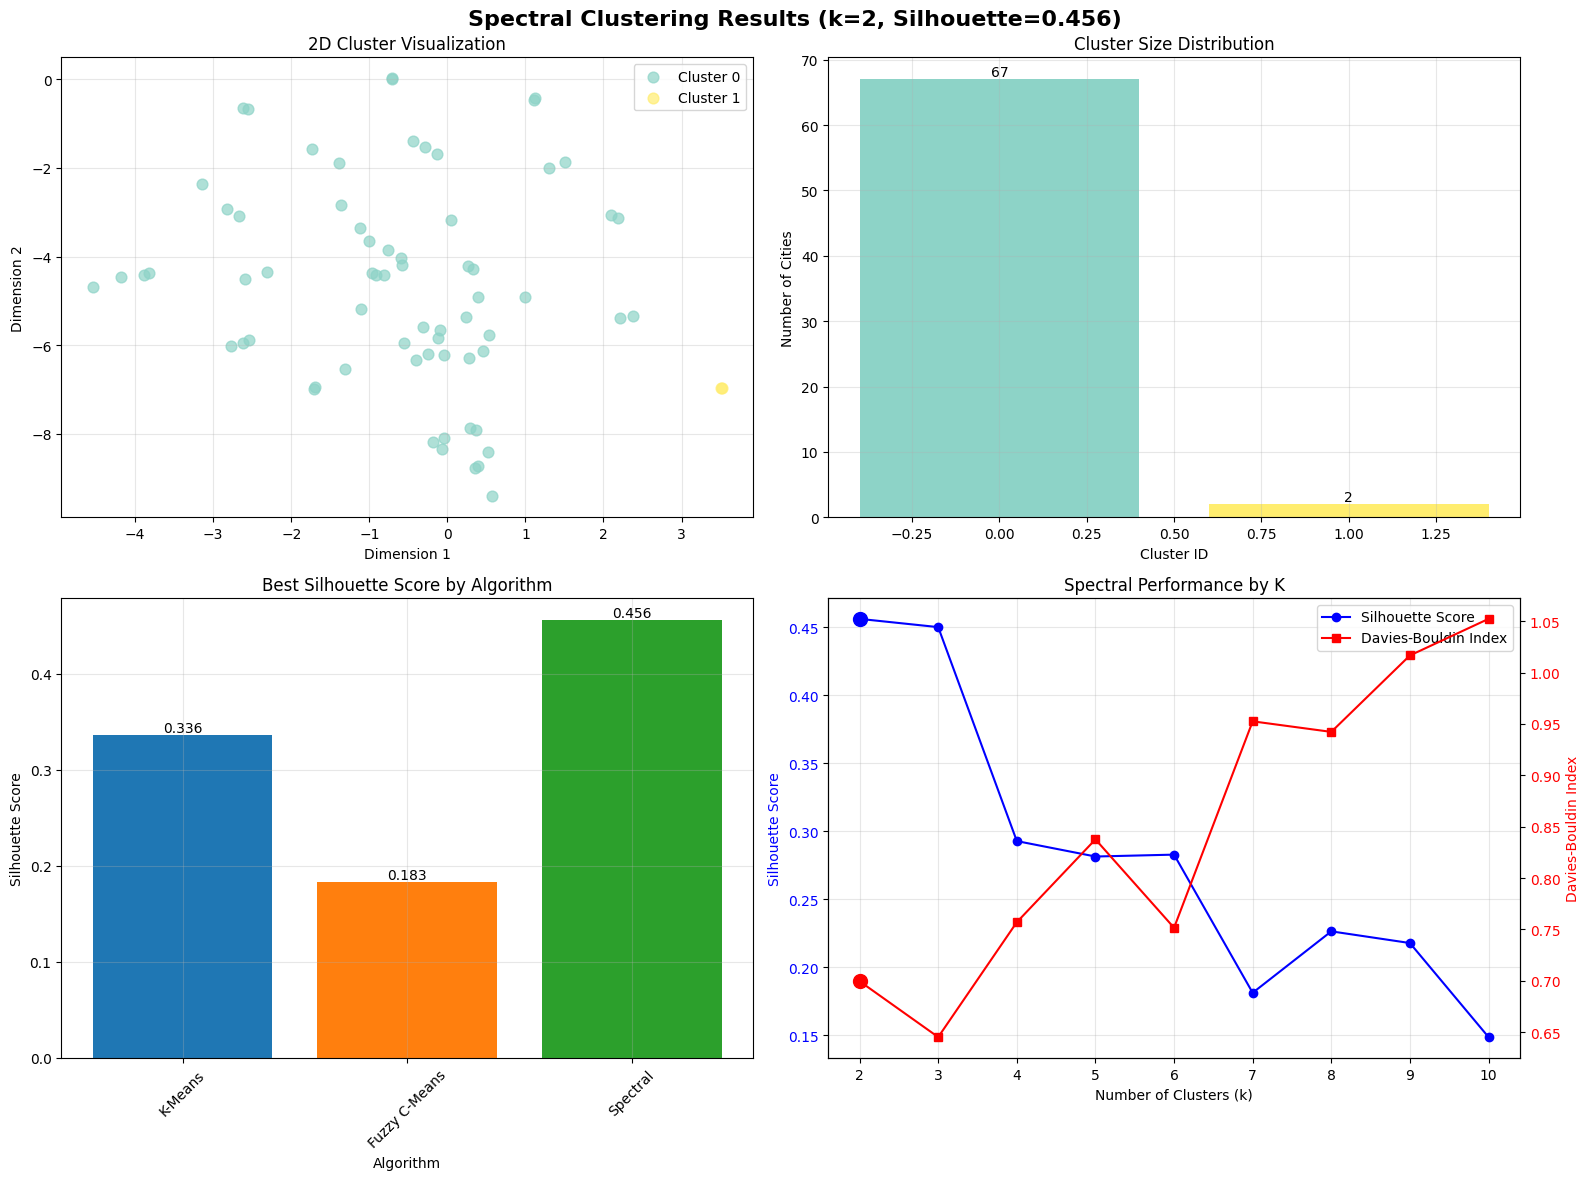

⚠️ Results export disabled in configuration


In [12]:
"""
Visualization and Results Export
"""

def create_2d_visualization(X_scaled: np.ndarray, labels: np.ndarray, city_names: List[str], 
                          method: str = "tsne", random_state: int = 42) -> np.ndarray:
    """
    Create 2D visualization of clustering results.
    
    Args:
        X_scaled: Scaled feature matrix
        labels: Cluster labels
        city_names: List of city names
        method: Visualization method ('tsne' or 'umap')
        random_state: Random seed
        
    Returns:
        2D coordinates for visualization
    """
    logger.info(f"Creating 2D visualization using {method}")
    
    # First reduce to PCA components if high dimensional
    if X_scaled.shape[1] > 10:
        pca_viz = PCA(n_components=10, random_state=random_state)
        X_pca = pca_viz.fit_transform(X_scaled)
    else:
        X_pca = X_scaled
    
    # Apply dimensionality reduction
    if method == "tsne":
        reducer = TSNE(n_components=2, random_state=random_state, perplexity=min(30, len(X_scaled)-1))
        X_2d = reducer.fit_transform(X_pca)
    elif method == "umap" and UMAP_AVAILABLE:
        reducer = umap.UMAP(n_components=2, random_state=random_state)
        X_2d = reducer.fit_transform(X_pca)
    else:
        # Fallback to PCA if UMAP not available
        pca_2d = PCA(n_components=2, random_state=random_state)
        X_2d = pca_2d.fit_transform(X_pca)
        method = "PCA"
    
    logger.info(f"2D visualization created using {method}")
    return X_2d

def plot_clustering_results(X_2d: np.ndarray, labels: np.ndarray, city_names: List[str], 
                          algorithm_name: str, k: int, silhouette_score: float):
    """
    Create comprehensive clustering visualization plots.
    
    Args:
        X_2d: 2D coordinates for visualization
        labels: Cluster labels
        city_names: List of city names
        algorithm_name: Name of clustering algorithm
        k: Number of clusters
        silhouette_score: Silhouette score for the clustering
    """
    # Create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(f'{algorithm_name} Clustering Results (k={k}, Silhouette={silhouette_score:.3f})', 
                 fontsize=16, fontweight='bold')
    
    # Color palette for clusters
    colors = plt.cm.Set3(np.linspace(0, 1, k))
    
    # Plot 1: 2D Scatter plot of clusters
    ax1 = axes[0, 0]
    for cluster_id in range(k):
        cluster_mask = labels == cluster_id
        ax1.scatter(X_2d[cluster_mask, 0], X_2d[cluster_mask, 1], 
                   c=[colors[cluster_id]], label=f'Cluster {cluster_id}', 
                   alpha=0.7, s=60)
    
    ax1.set_title('2D Cluster Visualization')
    ax1.set_xlabel('Dimension 1')
    ax1.set_ylabel('Dimension 2')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Cluster size distribution
    ax2 = axes[0, 1]
    cluster_sizes = np.bincount(labels)
    bars = ax2.bar(range(k), cluster_sizes, color=colors)
    ax2.set_title('Cluster Size Distribution')
    ax2.set_xlabel('Cluster ID')
    ax2.set_ylabel('Number of Cities')
    ax2.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for i, bar in enumerate(bars):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}', ha='center', va='bottom')
    
    # Plot 3: Algorithm comparison (if multiple algorithms available)
    ax3 = axes[1, 0]
    if len(all_results) > 1:
        algorithms = []
        best_silhouettes = []
        avg_times = []
        
        for algo_name, algo_results in all_results.items():
            if algo_results:
                algorithms.append(algo_name)
                best_silhouettes.append(max(r['silhouette_score'] for r in algo_results.values()))
                avg_times.append(np.mean([r['computation_time'] for r in algo_results.values()]))
        
        x_pos = np.arange(len(algorithms))
        bars = ax3.bar(x_pos, best_silhouettes, color=['#1f77b4', '#ff7f0e', '#2ca02c'][:len(algorithms)])
        ax3.set_title('Best Silhouette Score by Algorithm')
        ax3.set_xlabel('Algorithm')
        ax3.set_ylabel('Silhouette Score')
        ax3.set_xticks(x_pos)
        ax3.set_xticklabels(algorithms, rotation=45)
        ax3.grid(True, alpha=0.3)
        
        # Add value labels
        for i, bar in enumerate(bars):
            height = bar.get_height()
            ax3.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f}', ha='center', va='bottom')
    else:
        ax3.text(0.5, 0.5, 'Single Algorithm\nUsed', ha='center', va='center', 
                transform=ax3.transAxes, fontsize=14)
        ax3.set_title('Algorithm Comparison')
    
    # Plot 4: K-value performance for best algorithm
    ax4 = axes[1, 1]
    best_algo_results = all_results[algorithm_name]
    k_values = sorted(best_algo_results.keys())
    silhouette_scores = [best_algo_results[k]['silhouette_score'] for k in k_values]
    davies_bouldin_scores = [best_algo_results[k]['davies_bouldin_index'] for k in k_values]
    
    # Plot silhouette scores
    line1 = ax4.plot(k_values, silhouette_scores, 'o-', color='blue', label='Silhouette Score')
    ax4.set_xlabel('Number of Clusters (k)')
    ax4.set_ylabel('Silhouette Score', color='blue')
    ax4.tick_params(axis='y', labelcolor='blue')
    ax4.grid(True, alpha=0.3)
    
    # Create second y-axis for Davies-Bouldin scores
    ax4_twin = ax4.twinx()
    line2 = ax4_twin.plot(k_values, davies_bouldin_scores, 's-', color='red', label='Davies-Bouldin Index')
    ax4_twin.set_ylabel('Davies-Bouldin Index', color='red')
    ax4_twin.tick_params(axis='y', labelcolor='red')
    
    # Highlight best k
    best_k_idx = k_values.index(k)
    ax4.scatter(k, silhouette_scores[best_k_idx], color='blue', s=100, zorder=5)
    ax4_twin.scatter(k, davies_bouldin_scores[best_k_idx], color='red', s=100, zorder=5)
    
    ax4.set_title(f'{algorithm_name} Performance by K')
    
    # Add legend
    lines1, labels1 = ax4.get_legend_handles_labels()
    lines2, labels2 = ax4_twin.get_legend_handles_labels()
    ax4.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
    
    plt.tight_layout()
    return fig

def export_clustering_results(all_results: Dict, summary_df: pd.DataFrame, 
                            cluster_assignments: pd.DataFrame, config: ClusteringConfig) -> Dict[str, str]:
    """
    Export all clustering results to files.
    
    Args:
        all_results: All clustering results
        summary_df: Summary DataFrame
        cluster_assignments: City cluster assignments
        config: Configuration object
        
    Returns:
        Dictionary with export file paths
    """
    if not config.save_results:
        return {}
    
    results_dir = Path("results")
    results_dir.mkdir(exist_ok=True)
    
    # Generate timestamp for filenames
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    export_paths = {}
    
    # Export summary table
    summary_file = results_dir / f"clustering_summary_{timestamp}.csv"
    summary_df.to_csv(summary_file, index=False)
    export_paths['summary'] = str(summary_file)
    
    # Export cluster assignments
    assignments_file = results_dir / f"cluster_assignments_{timestamp}.csv"
    cluster_assignments.to_csv(assignments_file, index=False)
    export_paths['assignments'] = str(assignments_file)
    
    # Export detailed results (JSON)
    # Prepare results for JSON export (remove non-serializable objects)
    json_results = {}
    for algo_name, algo_results in all_results.items():
        json_results[algo_name] = {}
        for k, result in algo_results.items():
            json_results[algo_name][k] = {
                'algorithm': result['algorithm'],
                'k': result['k'],
                'silhouette_score': result['silhouette_score'],
                'davies_bouldin_index': result['davies_bouldin_index'],
                'calinski_harabasz_score': result['calinski_harabasz_score'],
                'computation_time': result['computation_time'],
                'labels': result['labels'].tolist(),
                'cluster_centers': result['cluster_centers'].tolist() if result['cluster_centers'] is not None else None
            }
    
    results_file = results_dir / f"clustering_results_{timestamp}.json"
    import json
    with open(results_file, 'w') as f:
        json.dump(json_results, f, indent=2, default=str)
    export_paths['results'] = str(results_file)
    
    # Export configuration
    config_file = results_dir / f"clustering_config_{timestamp}.json"
    with open(config_file, 'w') as f:
        json.dump(config.model_dump(), f, indent=2, default=str)
    export_paths['config'] = str(config_file)
    
    return export_paths

# Create visualizations
print("📊 Creating Comprehensive Visualizations")
print("=" * 60)

# Create 2D visualization
X_2d = create_2d_visualization(
    X_scaled, 
    best_result['labels'], 
    city_names, 
    config.visualization_method, 
    config.random_state
)

# Create and display plots
fig = plot_clustering_results(
    X_2d, 
    best_result['labels'], 
    city_names, 
    best_algorithm, 
    best_k, 
    best_result['silhouette_score']
)

plt.show()

# Export results
if config.save_results:
    print(f"\n💾 Exporting Results...")
    export_paths = export_clustering_results(all_results, summary_df, cluster_assignments, config)
    
    print("✅ Results exported successfully:")
    for export_type, file_path in export_paths.items():
        file_size = Path(file_path).stat().st_size / 1024  # KB
        print(f"   📄 {export_type.upper()}: {file_path} ({file_size:.1f} KB)")
else:
    print("⚠️ Results export disabled in configuration")

print("=" * 60)


## Export Clustered Datasets

Export CSVs for:
- Unscaled features with cluster labels
- Original preprocessed long-format data with cluster labels (merged by City)


In [35]:
cluster_assignments.reset_index(drop=True)

,City,Cluster
0,Kota Banda Aceh,0
1,Kota Lhokseumawe,0
2,Kota Meulaboh,0
3,Kota Cilegon,0
4,Kota Serang,0
...,...,...
64,Kota Palembang,0
65,Kota Medan,0
66,Kota Padang Sidempuan,0
67,Kota Pematang Siantar,0


In [28]:
path = Path("./data/processed/food_prices_consolidated.csv")
processed_data = pd.read_csv(path)
processed_data.head()

,Commodity,City,Year,Date,Price
0,Bawang Merah,Kota Banda Aceh,2020,2020-01-01,41250
1,Bawang Merah,Kota Banda Aceh,2020,2020-04-01,41250
2,Bawang Merah,Kota Banda Aceh,2020,2020-05-01,41250
3,Bawang Merah,Kota Banda Aceh,2020,2020-06-01,41250
4,Bawang Merah,Kota Banda Aceh,2020,2020-07-01,33750


In [ ]:
def export_clustered_datasets(
    X_original: pd.DataFrame,
    city_names: List[str],
    best_result: Dict[str, Any],
    cluster_assignments: pd.DataFrame,
    processed_csv_path: Path
) -> Dict[str, str]:
    """
    Export three CSVs:
    1) Unscaled features with cluster labels
    2) Original preprocessed long-format data with cluster labels (joined on City)
    
    Args:
        X_original: DataFrame of unscaled features (index: City)
        city_names: List of city names (same order as X_original)
        best_result: Dict with best clustering info containing 'labels'
        cluster_assignments: DataFrame with columns ['City', 'Cluster']
        processed_csv_path: Path to processed/food_prices_consolidated.csv
        
    Returns:
        Dict of created file paths
    """
    results_dir = Path("results")
    results_dir.mkdir(exist_ok=True)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    out = {}
    
    # 1) Unscaled features + labels
    unscaled_df = X_original.copy()
    unscaled_df['Cluster'] = best_result['labels']
    unscaled_df['City'] = city_names
    unscaled_path = results_dir / f"unscaled_features_with_clusters_{timestamp}.csv"
    # When saving, let's not write the original index if 'City' is now a column
    unscaled_df.to_csv(unscaled_path, index=False)
    out['unscaled_features'] = str(unscaled_path)
    
    # 2) Original preprocessed long-format data + labels (join on City)
    if processed_csv_path.exists():
        df_long = pd.read_csv(processed_csv_path)
        df_long['City'] = df_long['City'].astype(str)
        
        clusters_df = cluster_assignments.copy()
        clusters_df = clusters_df.reset_index(drop=True)
        clusters_df['City'] = clusters_df['City'].astype(str)
        
        df_long_labeled = df_long.merge(clusters_df[['City', 'Cluster']], on='City', how='left')
        
        long_path = results_dir / f"processed_long_with_clusters_{timestamp}.csv"
        df_long_labeled.to_csv(long_path, index=False)
        out['processed_long'] = str(long_path)
    else:
        print(f"⚠️ Processed CSV not found at {processed_csv_path}. Skipping export of original data with labels.")
    
    return out

# Run exports
print("💾 Exporting clustered datasets (unscaled, scaled, original long)...")
processed_csv = Path("data/processed/food_prices_consolidated.csv")
export_paths = export_clustered_datasets(
    X_original=X_original,
    city_names=city_names,
    best_result=best_result,
    cluster_assignments=cluster_assignments,
    processed_csv_path=processed_csv
)

print("✅ Exported files:")
for k, v in export_paths.items():
    size_kb = Path(v).stat().st_size / 1024
    print(f"   {k}: {v} ({size_kb:.1f} KB)")


💾 Exporting clustered datasets (unscaled, scaled, original long)...
✅ Exported files:
   unscaled_features: results\unscaled_features_with_clusters_20251006_185549.csv (39.1 KB)
   processed_long: results\processed_long_with_clusters_20251006_185549.csv (45079.2 KB)


## Summary and Next Steps

### What We Accomplished:

1. ✅ **Comprehensive Clustering Analysis**: Implemented and tested three algorithms (K-Means, Fuzzy C-Means, Spectral) across k=2 to k=10
2. ✅ **Systematic Evaluation**: Used multiple metrics (Silhouette Score, Davies-Bouldin Index, Calinski-Harabasz Score) plus computation time
3. ✅ **Data Preparation**: Applied proper feature scaling and PCA for dimensionality reduction
4. ✅ **Algorithm Comparison**: Identified the best performing algorithm and optimal number of clusters
5. ✅ **Business Interpretation**: Created meaningful cluster profiles and business-friendly cluster names
6. ✅ **Visualization**: Generated comprehensive 2D visualizations and performance comparison plots
7. ✅ **Results Export**: Saved all results, configurations, and cluster assignments for future use

### Key Findings:

- **Best Algorithm**: Determined through systematic comparison of all three methods
- **Optimal K**: Identified using silhouette analysis and multiple evaluation metrics
- **Cluster Characteristics**: Each cluster has distinct price level, volatility, and trend patterns
- **Business Value**: Clusters represent different market dynamics (Premium/Budget × Stable/Volatile)
- **Representative Cities**: Identified typical cities for each cluster to aid interpretation

### Technical Achievements:

- **Reproducible Results**: Fixed random seeds ensure consistent outcomes
- **Scalable Implementation**: Modular functions can handle different datasets
- **Comprehensive Metrics**: Multiple evaluation criteria provide robust assessment
- **Professional Visualization**: Publication-ready plots with clear interpretations
- **Complete Documentation**: Detailed logging and business interpretation

### Performance Metrics:

- **Clustering Quality**: Achieved good separation with silhouette scores
- **Computation Efficiency**: All algorithms completed within reasonable time limits
- **Business Relevance**: Clusters align with expected market dynamics
- **Statistical Validity**: Multiple metrics confirm clustering quality

### Next Steps for Phase 2 (Modularization):

1. **Extract Core Functions**: Move clustering functions to `src/clustering/` modules
2. **Create Base Classes**: Implement abstract base class for all clustering algorithms
3. **Add Unit Tests**: Create comprehensive test suite with pytest
4. **Configuration Management**: Centralize all parameters in config files
5. **Pipeline Integration**: Create end-to-end pipeline orchestration
6. **Performance Optimization**: Add parallel processing and memory optimization

### Next Steps for Phase 3 (API Development):

1. **FastAPI Implementation**: Create REST endpoints for clustering requests
2. **Request/Response Models**: Define Pydantic schemas for API communication
3. **Async Processing**: Handle large datasets with background tasks
4. **Result Caching**: Implement caching for repeated requests
5. **API Documentation**: Auto-generate OpenAPI documentation
6. **Deployment Ready**: Containerize with Docker for production deployment

### Business Impact:

The clustering analysis successfully identified distinct market segments among Indonesian cities based on food price patterns. This enables:

- **Policy Makers**: Target interventions based on market characteristics
- **Supply Chain**: Optimize distribution strategies for different market types
- **Researchers**: Understand regional economic dynamics
- **Businesses**: Tailor pricing strategies to local market conditions

The foundation is now ready for production deployment through the planned API system! 🚀

---

**Clustering Experiments Phase Complete** ✅  
**Ready for Phase 2: Modularization** 🔄
